In [21]:
%matplotlib inline

from osgeo import gdal, ogr, osr
import rasterio
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.mask import mask
from shapely.geometry import box
import geopandas as gpd
from fiona.crs import from_epsg
import pycrs
import matplotlib.pyplot as plt
import numpy as np
import os

## Explore the National Land Cover Database Raster

In [2]:
NLCD = r'C:\Users\zstat\Documents\RecurseCenter\EJ-analysis-map\Data\NLCD\NLCD2011_LC_New_Jersey\NLCD2011_LC_New_Jersey.tif'

In [4]:
# Check coordinate system and exclude values outside of the land cover classification numbers
with rasterio.open(NLCD) as nlcd_raster:
    crs = nlcd_raster.crs
    nlcd = nlcd_raster.read(1)
    #nlcd = nlcd.astype('f4')
    # Set nodata cells to 0
    nlcd[nlcd>95] = 0

crs

CRS({'proj': 'aea', 'lat_1': 29.5, 'lat_2': 45.5, 'lat_0': 23, 'lon_0': -96, 'x_0': 0, 'y_0': 0, 'datum': 'NAD83', 'units': 'm', 'no_defs': True})

In [5]:
#Identify the count of each value in the raster
(values, counts) = np.unique(nlcd, return_counts=True)
values = dict(zip(values, counts))
values

{0: 14129432,
 11: 3815733,
 21: 3106279,
 22: 1997288,
 23: 1160304,
 24: 522565,
 31: 158763,
 41: 4482318,
 42: 831432,
 43: 756489,
 52: 452705,
 71: 124792,
 81: 929177,
 82: 2069805,
 90: 3640100,
 95: 1050198}

<function matplotlib.pyplot.show(*args, **kw)>

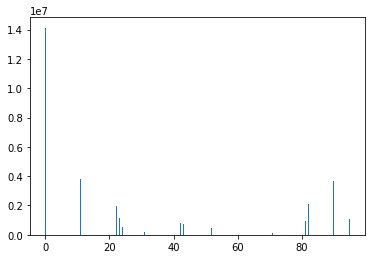

In [6]:
a=np.hstack(nlcd)
plt.hist(a, bins='auto')
plt.show

Text(0,0.5,'Row #')

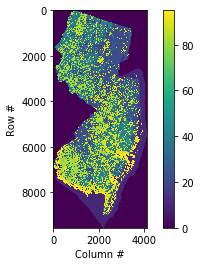

In [7]:
# Map array
plt.imshow(nlcd)
plt.colorbar()
plt.xlabel('Column #')
plt.ylabel('Row #')


In [8]:
# Create a function to only identify residential land
res_values =  [22, 23, 24]
non_res_values = [11,12,21,31,41,42,43,51,52,71,72,81,82,90,95]

def identify_res_land(array):
    for val in res_values:
        array[array==val] = 1
    for val in non_res_values:
        array[array==val] = 0
        
    return array

Text(0,0.5,'Row #')

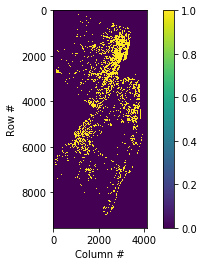

In [9]:
# Map new array
nj_res_land = identify_res_land(nlcd)

plt.imshow(nj_res_land)
leg = plt.colorbar()
plt.xlabel('Column #')
plt.ylabel('Row #')

In [10]:
# Preparing to export new array as a raster (GeoTIFF)
out_fp = r'C:\Users\zstat\Documents\RecurseCenter\EJ-analysis-map\Data\Created\NJ_res.tif'

In [11]:
# If the file exists, delete it
if os.path.exists(out_fp):
    os.remove(out_fp)
else:
    print("Can not delete the file as it doesn't exists")

In [12]:
# Get original raster's coordinate system and affine transformation
with rasterio.open(NLCD) as source_raster:
    source_crs = source_raster.crs
    source_transform = source_raster.transform
print(source_crs)
print(source_transform)

+datum=NAD83 +lat_0=23 +lat_1=29.5 +lat_2=45.5 +lon_0=-96 +no_defs +proj=aea +units=m +x_0=0 +y_0=0
| 30.00, 0.00, 1725255.00|
| 0.00,-30.00, 2236455.00|
| 0.00, 0.00, 1.00|


In [13]:
# Export array to raster(GeoTiff)
with rasterio.open(out_fp, 'w', driver='GTiff',
                   height=nj_res_land.shape[0], # Number of rows
                   width=nj_res_land.shape[1], # Number of columns
                   count=1, # Number of bands
                   dtype=nj_res_land.dtype, # This must match the datatpe of the array
                   crs=source_crs,
                   transform=source_transform
                  ) as out_raster:
    out_raster.write(nj_res_land, 1)
    out_raster.nodata = -1 # Set the raster's nodata value

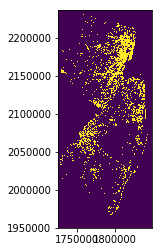

In [14]:
# Map and examine new raster
exported = rasterio.open(out_fp)
rasterio.plot.show(exported)

In [15]:
exported.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 4105,
 'height': 9556,
 'count': 1,
 'crs': CRS({'proj': 'aea', 'lat_1': 29.5, 'lat_2': 45.5, 'lat_0': 23, 'lon_0': -96, 'x_0': 0, 'y_0': 0, 'ellps': 'GRS80', 'towgs84': '0,0,0,0,0,0,0', 'units': 'm', 'no_defs': True}),
 'transform': Affine(30.0, 0.0, 1725255.0,
        0.0, -30.0, 2236455.0)}

In [18]:
# Get projection
src_ds = gdal.Open(r'C:\Users\zstat\Documents\RecurseCenter\EJ-analysis-map\Data\Created\NJ_res.tif')
prj = src_ds.GetProjection()
prj

'PROJCS["unnamed",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.2572221010042,AUTHORITY["EPSG","7019"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]'

In [20]:
# Get transform
src_ds = gdal.Open(r'C:\Users\zstat\Documents\RecurseCenter\EJ-analysis-map\Data\Created\NJ_res.tif')
geom = src_ds.GetGeoTransform()
geom

(1725255.0, 30.0, 0.0, 2236455.0, 0.0, -30.0)

## Polygonize the New Raster

In [22]:
gdal.UseExceptions

<function osgeo.gdal.UseExceptions(*args)>

In [23]:
# Get raster datsource
src_raster = gdal.Open(r'C:\Users\zstat\Documents\RecurseCenter\EJ-analysis-map\Data\Created\NJ_res.tif')
band = src_raster.GetRasterBand(1)

In [24]:
out_shp = r'C:\Users\zstat\Documents\RecurseCenter\EJ-analysis-map\Data\Created\nj_res.shp'
driver = ogr.GetDriverByName("ESRI Shapefile")
# If shapefile already exists, delete it
if os.path.exists(out_shp):
    driver.DeleteDataSource(out_shp)

In [27]:
out_ds = driver.CreateDataSource(out_shp)
# get proj from raster
srs = osr.SpatialReference()
srs.ImportFromWkt( src_raster.GetProjectionRef() )

0

In [28]:
# Create layer with projection
out_layer = out_ds.CreateLayer(out_shp, srs)

In [30]:
# Add class column to shapefile
new_field = ogr.FieldDefn('Class', ogr.OFTInteger)
out_layer.CreateField(new_field)

0

In [ ]:
# Polygonize
gdal.Polygonize(band, None, out_layer, 0, [], callback=None)

In [ ]:
out_ds.Destroy()
src_raster = None
band = None